In [1]:
from getpass import getpass
import pandas as pd
from mysql.connector import connect, Error
import warnings
import requests
import codecs
import time
import re
import datetime
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
import math

In [3]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

In [4]:
#ignore warnings
warnings.filterwarnings("ignore")

# connet to server

In [5]:
#connect to sever
try:
    conn = connect(
        host="localhost",
        user="root", #input("Enter username: ")
        password="guoxiaochen1997", #getpass("Enter password: ")
        database="Masks") #after first run, needs to be left blank on first run to create DB
    cursor = conn.cursor()
    print(conn)
except Error as e:
    print(e)

# join tables

In [6]:
#join datedprices_amazon and datedprices_amazon on year-week
#if amazon price is -1, use market price to instead
sql = "SELECT COALESCE(asin,new_asin) AS 'asin', COALESCE(time,new_time) AS 'time',\
CASE WHEN price IS NULL THEN market_price WHEN price  = -1 THEN market_price ELSE price END AS 'price' \
FROM \
(SELECT a.*, b.asin as 'new_asin', b.time AS 'new_time', b.price AS 'market_price' \
FROM datedprices_amazon AS a LEFT JOIN datedprices_new AS b ON a.asin = b.asin AND a.time = b.time \
UNION \
SELECT a.*, b.asin as 'new_asin', b.time AS 'new_time', b.price AS 'market_price' \
FROM datedprices_amazon AS a RIGHT JOIN datedprices_new AS b ON a.asin = b.asin AND a.time = b.time) AS c;"


data_price_week = pd.read_sql(sql,conn)

#save the data
#data_week.to_csv('sales_ranks&amazon_prices_week.csv') #too many data to save in excel

In [7]:
data_price_week.sort_values("time")

,asin,time,price
3401,B000RFP4E0,201112,1310.0
80864,B000CCI4YU,201112,895.0
83905,B0013Z0TV6,201112,1590.0
79760,B00006IUTQ,201112,355.0
83989,B001564URC,201112,999.0
...,...,...,...
227906,B08L7ST494,202137,1599.0
68652,B08FLVDBKP,202137,1026.0
68591,B08FLHZMQT,202137,1947.0
250158,B094348KR2,202137,599.0


# analysis

### Masks Availability Analysis

In [8]:
#In this part, we will focus on only price data since price shows the availabity of the masks.
#count of asin of original price data
data_price_week.groupby("asin").count()

,time,price
asin,,
B00004Z4EB,61,61
B00005NFBD,251,249
B00005NFBJ,219,215
B00006IUTQ,202,202
B0000TN7MY,6,6
...,...,...
B09FLJHK21,1,1
B09FLVTRKL,2,2
B09FM1CNLG,1,1


In [9]:
#show the time of original data
all_time_avaliable = data_price_week.groupby("time").count().reset_index()["time"]

In [10]:
#test if there are some weeks that doesn't have information about price and sales ranks
a = tuple(np.arange(201505,201552))
b = tuple(np.arange(201601,201652))
c = tuple(np.arange(201701,201752))
d = tuple(np.arange(201801,201852))
e = tuple(np.arange(201901,201952))
f = tuple(np.arange(202001,202052))
g = tuple(np.arange(202101,202140))
all_time = a+b+c+d+e+f+g

In [11]:
#print week that doesn't have existing information
non_existing = list(set(all_time) - (set(all_time_avaliable)))
non_existing.sort()
non_existing
#We have information in most past 6 years

[201511, 201512, 202138, 202139]

In [12]:
#get rid of -1 price (-1 means that there was no offer available there)
data_price_avaliable = data_price_week.drop(data_price_week[(data_price_week['price']==-1)].index)

In [13]:
# How many numbers of masks were available/ out of stock(price -1) in different time?

In [14]:
#the total number of avaliable masks in different times
total_num_ava= data_price_avaliable.groupby(['time'])['asin'].nunique().reset_index()

In [15]:
total_num_ava

,time,asin
0,201112,29
1,201113,16
2,201114,43
3,201115,21
4,201116,13
...,...,...
539,202133,3214
540,202134,3224
541,202135,2994
542,202136,2270


In [16]:
#display all the rows
#pd.set_option('display.max_rows',None)
total_num_ava['asin']

0        29
1        16
2        43
3        21
4        13
       ... 
539    3214
540    3224
541    2994
542    2270
543    1334
Name: asin, Length: 544, dtype: int64

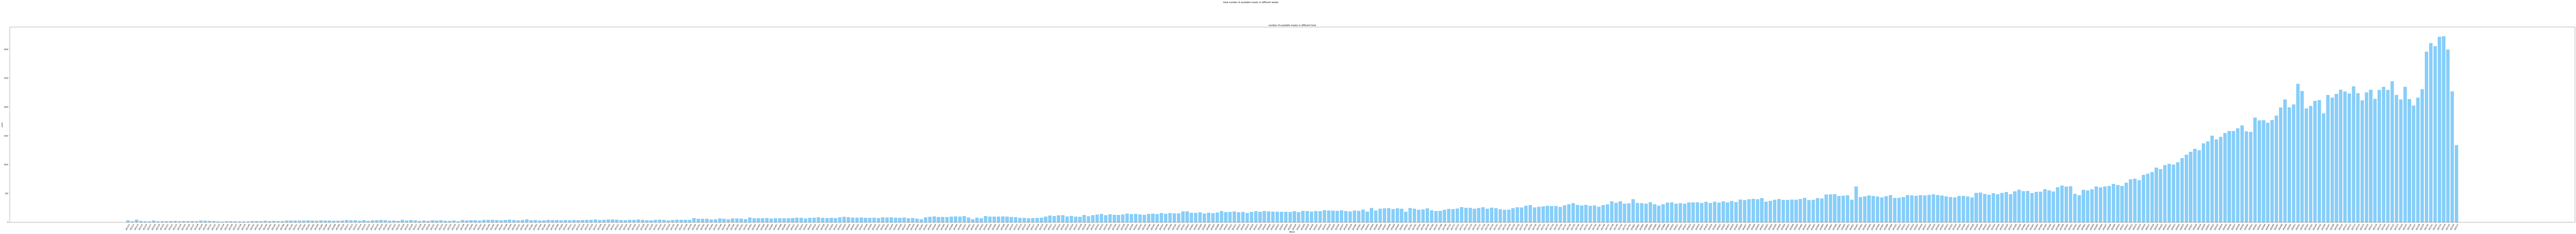

In [17]:
fig = plt.figure(figsize=(256, 20))
fig.suptitle('total number of available masks in different weeks')
index = np.arange(544)
values = total_num_ava['asin']

# width
width = 0.8

# plot the bar
plt.bar(index, values, width, label="number of available masks", color="#87CEFA")

plt.xlabel('Weeks')
plt.ylabel('count')
plt.title('number of available masks in different time')
plt.xticks(index, total_num_ava['time'], rotation = 60)

plt.show()

In [18]:
#the number of unavailable masks in different times (price = -1)
data_price_unavaliable = data_price_week[(data_price_week['price']==-1)]
total_num_unava= data_price_unavaliable.groupby(['time'])['asin'].nunique().reset_index()
total_num_unava

,time,asin
0,201115,1
1,201120,1
2,201122,1
3,201124,1
4,201127,1
...,...,...
401,202133,320
402,202134,326
403,202135,261
404,202136,257


In [19]:
#there are only 406 weeks in unavailble offer data, we need to make sure that we use the same timeline
time_diff = list(set(total_num_ava['time'])-set(total_num_unava['time']))

len(time_diff)#138

total_num_unava_diff =[0]*138

diff = pd.DataFrame(time_diff, columns = ["time"])
diff["asin"] = total_num_unava_diff

In [20]:
#union the diff and total_num_unava
total_num_unava = total_num_unava.append(diff).sort_values('time').reset_index()

In [21]:
total_num_mask = pd.DataFrame(total_num_ava, columns = ["time"])
total_num_mask["ava_count"] = total_num_ava["asin"]
total_num_mask["unava_count"] = total_num_unava["asin"]
total_num_mask["unava_count_percent"] = total_num_mask.apply(lambda x:x['unava_count']/(x['ava_count']+x['unava_count']),axis =1)

In [22]:
total_num_mask

,time,ava_count,unava_count,unava_count_percent
0,201112,29,0,0.000000
1,201113,16,0,0.000000
2,201114,43,0,0.000000
3,201115,21,1,0.045455
4,201116,13,0,0.000000
...,...,...,...,...
539,202133,3214,320,0.090549
540,202134,3224,326,0.091831
541,202135,2994,261,0.080184
542,202136,2270,257,0.101702


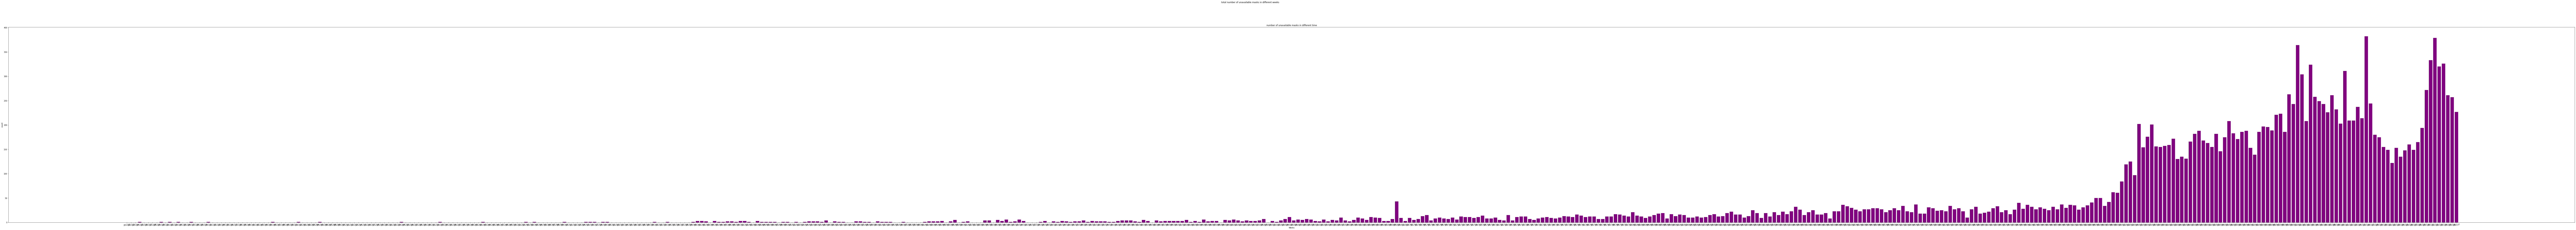

In [23]:
fig = plt.figure(figsize=(256, 20))
fig.suptitle('total number of unavailable masks in different weeks')
index = np.arange(544)
values = total_num_unava['asin']

# width
width = 0.8

# plot the bar
plt.bar(index, values, width, label="number of unavailable masks", color="purple")

plt.xlabel('Weeks')
plt.ylabel('count')
plt.title('number of unavailable masks in different time')
plt.xticks(index, total_num_unava['time'], rotation = 6)

plt.show()

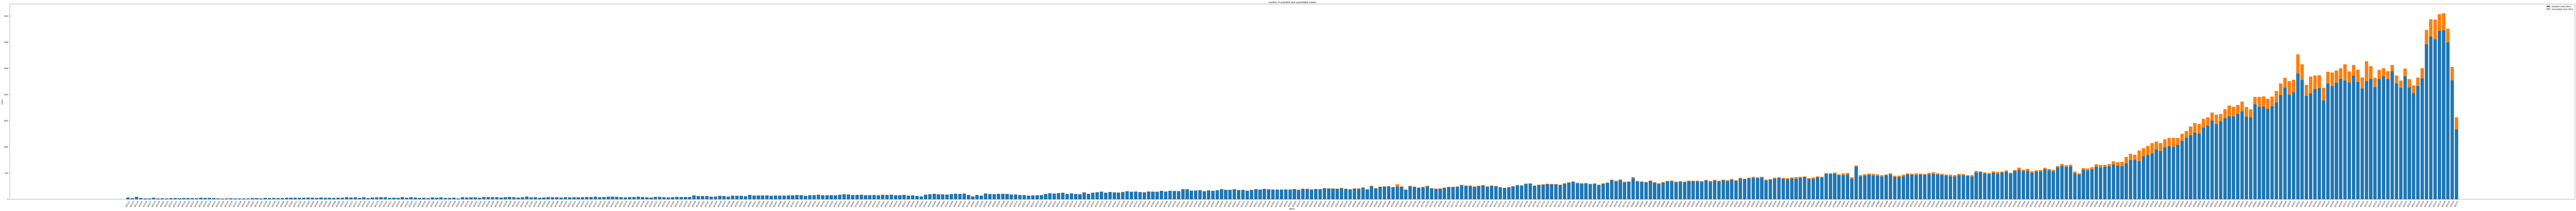

In [24]:
#stacked bar chart of total numbers of masks in different time
fig = plt.figure(figsize=(256, 20))
index = np.arange(544)
values = total_num_ava['asin']
values_un = total_num_unava['asin']
width = 0.8

plt.bar(index, values, width, label='Available mask offers')
plt.bar(index, values_un, width, bottom=values,
       label='Unavaliable mask offers')

plt.ylabel('Count')
plt.xlabel('Weeks')
plt.title('number of avaliable and unavailable masks')
plt.xticks(index, total_num_ava['time'],rotation = 60)
plt.legend()

plt.show()

# As we can see from the plot, the total number of mask offers started increasing from the 20th week of 2020, which is the beginning of the pandemic in United States. But the percent of unavailable offers also increased in the meantime.

### What’s the relationship between price and sales ranks(sales) in same category in different time?

In [25]:
#join price and datedsales_ranks on year-month
sql1 = "WITH c AS (SELECT COALESCE(asin,new_asin) AS 'asin', COALESCE(time,new_time) AS 'time',\
CASE WHEN price IS NULL THEN market_price WHEN price  = -1 THEN market_price ELSE price END AS 'price' \
FROM \
(SELECT a.*, b.asin as 'new_asin', b.time AS 'new_time', b.price AS 'market_price' \
FROM datedprices_amazon AS a LEFT JOIN datedprices_new AS b ON a.asin = b.asin AND a.time = b.time \
UNION \
SELECT a.*, b.asin as 'new_asin', b.time AS 'new_time', b.price AS 'market_price' \
FROM datedprices_amazon AS a RIGHT JOIN datedprices_new AS b ON a.asin = b.asin AND a.time = b.time) AS c) \
SELECT c.*, sales_rank, category \
FROM c INNER JOIN datedsales_ranks AS d \
ON c.asin = d.asin AND c.time = d.time;" 

data_price_salesrank_week = pd.read_sql(sql1,conn)

#save the data
#data_month.to_csv('sales_ranks&amazon_prices_month.csv') #too many data to save in excel

In [26]:
data_price_salesrank_week.sort_values("time")

,asin,time,price,sales_rank,category
113798,B000CCI4YU,201505,1295.0,1449,3760901
19248,B008MCV2KU,201505,2787.0,12228,228013
3981,B000XBFJP2,201505,3894.0,22781,228013
127440,B009NKTGXA,201505,1900.0,2129,3760901
137108,B00GX7NU8I,201505,1413.0,66502,3760901
...,...,...,...,...,...
112395,B09DFWFWGG,202137,657.0,5928,21233678011
112404,B09DG38ZP6,202137,1169.0,4394,16035056011
392918,B094348KR2,202137,599.0,43303,3760911
112429,B09DGJZ3T1,202137,1390.0,-1,-1


In [27]:
#get rid of all the -1 in sales rank and price
data_clean = data_price_salesrank_week.drop(data_price_salesrank_week[(data_price_salesrank_week['price']==-1)|(data_price_salesrank_week['sales_rank']==-1)].index)

In [28]:
#count the unique asins in diffrent categories
data_clean.groupby(['category'])['asin'].nunique().reset_index().sort_values('asin')

,category,asin
745,23566055011,1
359,367125011,1
358,360832011,1
651,13861693011,1
356,318140011,1
...,...,...
314,16310091,2287
141,3760911,2823
243,11061121,2832
715,21233678011,2839


In [29]:
#count the entries in diffrent categories
data_clean.groupby(['category']).size().reset_index(name = 'count').sort_values('count')

,category,count
745,23566055011,1
614,11117588011,1
177,3777801,1
609,10844426011,1
180,3778131,1
...,...,...
715,21233678011,20247
314,16310091,25523
243,11061121,36281
140,3760901,59189


In [30]:
#category 3760911 contains most entries ans unique asins

In [31]:
Mask_data_3760911 = data_clean[data_clean['category']==3760911]

In [32]:
Mask_data_3760911

,asin,time,price,sales_rank,category
119,B00005NFBD,201513,327.0,8011,3760911
120,B00005NFBD,201616,339.0,5005,3760911
121,B00005NFBD,201617,327.0,6023,3760911
122,B00005NFBD,201618,327.0,5699,3760911
123,B00005NFBD,201619,327.0,6017,3760911
...,...,...,...,...,...
396705,B09DYD59KD,202136,799.0,76506,3760911
396707,B09DYD59KD,202137,699.0,69343,3760911
396730,B09F3TDD6X,202136,2030.0,134452,3760911
396732,B09F3TDD6X,202137,1999.0,116474,3760911


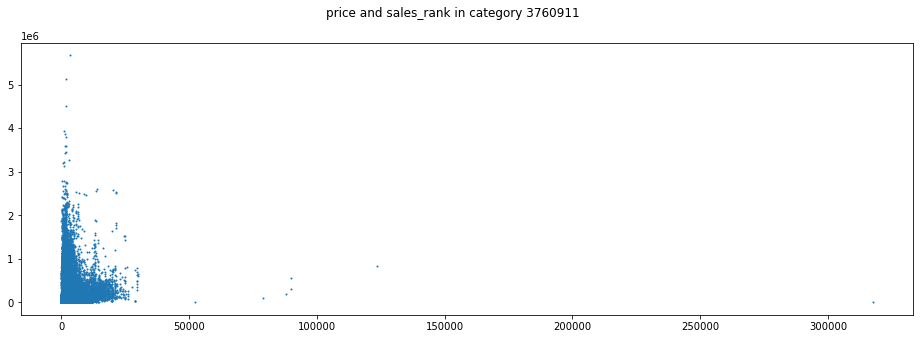

In [33]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('price and sales_rank in category 3760911')
price = Mask_data_3760911['price']
sales_rank = Mask_data_3760911['sales_rank']
plt.scatter(price,sales_rank,s=1.)
plt.show()

In [34]:
print(max(sales_rank))
print(min(sales_rank))

5674973
1


In [35]:
#use log_price and log_sales
log_price = np.log(price)
log_sales = np.log(max(sales_rank)-sales_rank+1)

In [36]:
log_price_100 = np.log(price/100) #the accurate price

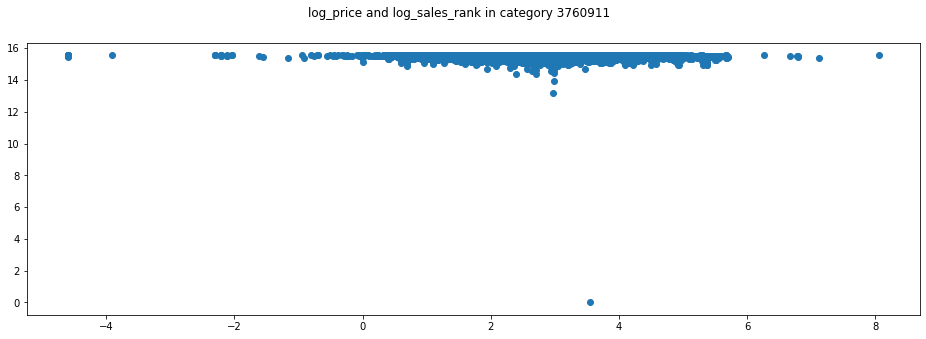

In [37]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle('log_price and log_sales_rank in category 3760911')
plt.scatter(log_price_100,log_sales)
plt.show()

In [38]:
Mask_data_3760911["log_price_100"] = log_price_100
Mask_data_3760911["log_sales"] = log_sales

In [39]:
#before pandemic/before February 3 — US Declares Public Health Emergency/before the 5th week of 2020
Mask_data_3760911_before = Mask_data_3760911[(Mask_data_3760911['time']<202005)]

In [40]:
Mask_data_3760911_before

,asin,time,price,sales_rank,category,log_price_100,log_sales
119,B00005NFBD,201513,327.0,8011,3760911,1.184790,15.550164
120,B00005NFBD,201616,339.0,5005,3760911,1.220830,15.550694
121,B00005NFBD,201617,327.0,6023,3760911,1.184790,15.550515
122,B00005NFBD,201618,327.0,5699,3760911,1.184790,15.550572
123,B00005NFBD,201619,327.0,6017,3760911,1.184790,15.550516
...,...,...,...,...,...,...,...
240940,B082XG6BJJ,202004,2395.0,22810,3760911,3.175968,15.547549
241417,B083645ZVB,202001,1899.0,3598040,3760911,2.943913,14.546403
241474,B0837D27QC,202003,9299.0,219097,3760911,4.532492,15.512204
241703,B083G4Y8MD,202004,1500.0,241320,3760911,2.708050,15.508122


In [41]:
#linear regression by using statsmodel
fit = ols('log_sales ~ log_price_100 + C(asin)', data=Mask_data_3760911_before).fit()
fit.summary()
#the coefficient of log_price_100 is -0.0128

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     11.71
Date:                Thu, 30 Sep 2021   Prob (F-statistic):               0.00
Time:                        01:01:03   Log-Likelihood:                 45395.
No. Observations:               42025   AIC:                        -8.837e+04
Df Residuals:                   40813   BIC:                        -7.789e+04
Df Model:                        1211                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.5606      0.008   1854.105      0.000      15.544      15.577
C(asin)[T.B00005NFBJ]     0.0042      0.013      0.327      0.743      -0.021       0.029
C(asin)[T.B00019ODA8]    -0.0204      0.013     -1.629      0.103      -0.045       0.004
C(asin)[T.B0001EKTTC]     0.0163      0.013      1.276      0.202      -0.009       0.041
C(asin)[T.B0001EKU28]     0.0278      0.011      2.618      0.009       0.007       0.049
C(asin)[T.B0009DSOCE]     0.0439      0.016      2.729      0.006       0.012       0.075
C(asin)[T.B000AJ23EC]     0.0278      0.013      2.161      0.031       0.003       0.053
C(asin)[T.B000FGXB2S]     0.0227      0.012      1.878      0.060      -0.001       0.046
C(asin)[T.B000GDDKJO]     0.0261      0.011      2.480      0.013       0.005       0.047
C(asin)[T.B000GZBWH4]    -0.0256      0.011     -2.232      0.026      -0.048      -0.003
C(asin)[T.B000NSIGE6]     0.0105      0.011      0.941      0.347      -0.011       0.032
C(asin)[T.B000PINOJQ]     0.0210      0.010      2.023      0.043       0.001       0.041
C(asin)[T.B000Q95V4U]     0.0040      0.019      0.215      0.830      -0.033       0.041
C(asin)[T.B000T2FVZS]     0.0045      0.013      0.354      0.723      -0.020       0.029
C(asin)[T.B000VPPUEA]     0.0173      0.011      1.505      0.132      -0.005       0.040
C(asin)[T.B000YOMR8A]     0.0231      0.014      1.659      0.097      -0.004       0.050
C(asin)[T.B000YTA4QM]     0.0317      0.011      2.836      0.005       0.010       0.054
C(asin)[T.B000YZDVYS]     0.0187      0.011      1.743      0.081      -0.002       0.040
C(asin)[T.B000ZEA6WS]    -0.0008      0.011     -0.070      0.944      -0.022       0.021
C(asin)[T.B001377JEY]     0.0272      0.013      2.173      0.030       0.003       0.052
C(asin)[T.B00139CT4M]    -0.0118      0.018     -0.665      0.506      -0.047       0.023
C(asin)[T.B0013FFYXE]     0.0039      0.017      0.223      0.824      -0.030       0.038
C(asin)[T.B0014272VI]     0.0004      0.042      0.010      0.992      -0.083       0.084
C(asin)[T.B0015ZC124]     0.0207      0.019      1.068      0.286      -0.017       0.059
C(asin)[T.B0015ZC156]     0.0112      0.021      0.521      0.602      -0.031       0.053
C(asin)[T.B0015ZC1FG]     0.0230      0.016      1.434      0.152      -0.008       0.054
C(asin)[T.B00172LM84]     0.0235      0.020      1.168      0.243      -0.016       0.063
C(asin)[T.B00172NNIG]     0.0150      0.020      0.762      0.446      -0.024       0.054
C(asin)[T.B00172PCBW]    -0.0025      0.027     -0.093      0.926      -0.055       0.050
C(asin)[T.B00175S7T8]     0.0221      0.015      1.429      0.153      -0.008       0.052
C(asin)[T.B0018AMJ96]     0.0200      0.017      1.205      0.228      -0.013       0.053
C(asin)[T.B001B8M3P0]  

In [44]:
#during pandemic/after February 3 — US Declares Public Health Emergency & before people can be vaccinated
#/after the 5th week of 2020 & before the 14th week of 2021
Mask_data_3760911_during = Mask_data_3760911[(Mask_data_3760911['time']>=202005)&(Mask_data_3760911['time']<202114)]

In [45]:
Mask_data_3760911_during

,asin,time,price,sales_rank,category,log_price_100,log_sales
170,B00005NFBD,202005,327.0,17658,3760911,1.184790,15.548460
171,B00005NFBD,202006,429.0,22584,3760911,1.456287,15.547589
172,B00005NFBD,202007,429.0,23017,3760911,1.456287,15.547512
173,B00005NFBD,202008,420.0,21454,3760911,1.435085,15.547789
174,B00005NFBD,202009,420.0,31215,3760911,1.435085,15.546061
...,...,...,...,...,...,...,...
388404,B08YJXNNWN,202113,1248.0,18046,3760911,2.524127,15.548392
388430,B08YK3RRJC,202113,1299.0,555042,3760911,2.564180,15.448652
389099,B08Z1MKYR2,202112,2599.0,227245,3760911,3.257712,15.510709
389144,B08Z3CBGH6,202112,4990.0,72937,3760911,3.910021,15.538641


In [46]:
#linear regression by using statsmodel
fit = ols('log_sales ~ log_price_100 + C(asin)', data=Mask_data_3760911_during).fit()
fit.summary()
#the coefficient of log_price_100 is -0.0076

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     19.73
Date:                Thu, 30 Sep 2021   Prob (F-statistic):               0.00
Time:                        01:08:41   Log-Likelihood:                 64479.
No. Observations:               27440   AIC:                        -1.245e+05
Df Residuals:                   25199   BIC:                        -1.061e+05
Df Model:                        2240                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.5578      0.003   4863.672      0.000      15.552      15.564
C(asin)[T.B00005NFBJ]     0.0015      0.004      0.345      0.730      -0.007       0.010
C(asin)[T.B00019ODA8]    -0.0348      0.007     -4.872      0.000      -0.049      -0.021
C(asin)[T.B0001EKTTC]    -0.0135      0.009     -1.539      0.124      -0.031       0.004
C(asin)[T.B0001EKU28]     0.0115      0.009      1.322      0.186      -0.006       0.029
C(asin)[T.B0009DSOCE]     0.0238      0.009      2.684      0.007       0.006       0.041
C(asin)[T.B000AJ23EC]   8.07e-05      0.008      0.011      0.991      -0.015       0.015
C(asin)[T.B000FGXB2S]     0.0028      0.005      0.536      0.592      -0.007       0.013
C(asin)[T.B000GDDKJO]     0.0055      0.007      0.773      0.440      -0.008       0.019
C(asin)[T.B000GZBWH4]    -0.0299      0.007     -4.302      0.000      -0.043      -0.016
C(asin)[T.B000NSIGE6]     0.0042      0.005      0.863      0.388      -0.005       0.014
C(asin)[T.B000PINOJQ]     0.0098      0.006      1.743      0.081      -0.001       0.021
C(asin)[T.B000Q95V4U]    -0.0234      0.005     -4.963      0.000      -0.033      -0.014
C(asin)[T.B000T2FVZS]    -0.0166      0.005     -3.015      0.003      -0.027      -0.006
C(asin)[T.B000VPPUEA]     0.0077      0.006      1.188      0.235      -0.005       0.020
C(asin)[T.B000YOMR8A]     0.0068      0.014      0.474      0.635      -0.021       0.035
C(asin)[T.B000YTA4QM]    -0.0040      0.006     -0.616      0.538      -0.017       0.009
C(asin)[T.B000YZDVYS]     0.0037      0.005      0.775      0.439      -0.006       0.013
C(asin)[T.B000ZEA6WS]     0.0017      0.004      0.377      0.706      -0.007       0.010
C(asin)[T.B001377JEY]    -0.0039      0.008     -0.500      0.617      -0.019       0.011
C(asin)[T.B00139CT4M]    -0.0061      0.011     -0.538      0.590      -0.028       0.016
C(asin)[T.B0013FFYXE]    -0.0132      0.014     -0.918      0.359      -0.041       0.015
C(asin)[T.B0014272VI]     0.0053      0.005      1.117      0.264      -0.004       0.015
C(asin)[T.B0015ZC124]     0.0081      0.007      1.190      0.234      -0.005       0.022
C(asin)[T.B0015ZC156]    -0.0100      0.011     -0.889      0.374      -0.032       0.012
C(asin)[T.B0015ZC1FG]     0.0118      0.007      1.765      0.078      -0.001       0.025
C(asin)[T.B00172LM84]     0.0078      0.009      0.902      0.367      -0.009       0.025
C(asin)[T.B00172NNIG]     0.0018      0.007      0.248      0.804      -0.012       0.016
C(asin)[T.B00172PCBW]    -0.0320      0.010     -3.093      0.002      -0.052      -0.012
C(asin)[T.B00175S7T8]    -0.0037      0.013     -0.296      0.767      -0.028       0.021
C(asin)[T.B0018AMJ96]     0.0108      0.010      1.107      0.268      -0.008       0.030
C(asin)[T.B001B8M3P0]  

In [49]:
#after people can be vaccinated
#/after the 14th week of 2021
Mask_data_3760911_after = Mask_data_3760911[(Mask_data_3760911['time']>=202114)]

In [50]:
Mask_data_3760911_after

,asin,time,price,sales_rank,category,log_price_100,log_sales
269,B00005NFBD,202114,327.0,8706,3760911,1.184790,15.550041
271,B00005NFBD,202115,505.0,7787,3760911,1.619388,15.550203
273,B00005NFBD,202116,327.0,9558,3760911,1.184790,15.549891
275,B00005NFBD,202117,327.0,5799,3760911,1.184790,15.550554
277,B00005NFBD,202118,327.0,10053,3760911,1.184790,15.549804
...,...,...,...,...,...,...,...
396705,B09DYD59KD,202136,799.0,76506,3760911,2.078191,15.538004
396707,B09DYD59KD,202137,699.0,69343,3760911,1.944481,15.539282
396730,B09F3TDD6X,202136,2030.0,134452,3760911,3.010621,15.527599
396732,B09F3TDD6X,202137,1999.0,116474,3760911,2.995232,15.530839


In [51]:
#linear regression by using statsmodel
fit = ols('log_sales ~ log_price_100 + C(asin)', data=Mask_data_3760911_after).fit()
fit.summary()
#the coefficient of log_price_100 is -0.0006

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     14.31
Date:                Thu, 30 Sep 2021   Prob (F-statistic):               0.00
Time:                        01:11:24   Log-Likelihood:                 41283.
No. Observations:               14933   AIC:                        -7.766e+04
Df Residuals:                   12478   BIC:                        -5.897e+04
Df Model:                        2454                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.5506      0.004   4381.577      0.000      15.544      15.558
C(asin)[T.B00005NFBJ]    -0.0015      0.005     -0.297      0.766      -0.011       0.008
C(asin)[T.B00019ODA8]    -0.0170      0.009     -1.883      0.060      -0.035       0.001
C(asin)[T.B0001EKU28]    -0.0046      0.017     -0.271      0.787      -0.038       0.029
C(asin)[T.B0009DSOCE]    -0.0006      0.007     -0.084      0.933      -0.015       0.014
C(asin)[T.B000AJ23EC]    -0.0101      0.008     -1.272      0.204      -0.026       0.005
C(asin)[T.B000FGXB2S]    -0.0186      0.006     -2.892      0.004      -0.031      -0.006
C(asin)[T.B000GDDKJO]    -0.0100      0.017     -0.585      0.559      -0.044       0.024
C(asin)[T.B000GZBWH4]    -0.0279      0.007     -3.762      0.000      -0.042      -0.013
C(asin)[T.B000NSIGE6]    -0.0084      0.005     -1.551      0.121      -0.019       0.002
C(asin)[T.B000PINOJQ]     0.0006      0.006      0.087      0.931      -0.012       0.013
C(asin)[T.B000Q95V4U]    -0.0203      0.005     -3.925      0.000      -0.030      -0.010
C(asin)[T.B000T2FVZS]    -0.0293      0.006     -4.766      0.000      -0.041      -0.017
C(asin)[T.B000VPPUEA]     0.0023      0.017      0.134      0.894      -0.031       0.036
C(asin)[T.B000YOMR8A]    -0.0130      0.012     -1.045      0.296      -0.037       0.011
C(asin)[T.B000YTA4QM]    -0.0153      0.006     -2.660      0.008      -0.027      -0.004
C(asin)[T.B000YZDVYS]    -0.0074      0.006     -1.333      0.183      -0.018       0.003
C(asin)[T.B000ZEA6WS]    -0.0058      0.005     -1.172      0.241      -0.015       0.004
C(asin)[T.B00139CT4M]    -0.0338      0.012     -2.734      0.006      -0.058      -0.010
C(asin)[T.B0014272VI]    -0.0028      0.018     -0.157      0.875      -0.037       0.032
C(asin)[T.B0015ZC124]    -0.0048      0.008     -0.628      0.530      -0.020       0.010
C(asin)[T.B0015ZC156]    -0.0184      0.017     -1.079      0.281      -0.052       0.015
C(asin)[T.B0015ZC1FG]    -0.0003      0.007     -0.042      0.967      -0.014       0.013
C(asin)[T.B00172LM84]    -0.0106      0.017     -0.622      0.534      -0.044       0.023
C(asin)[T.B00172NNIG]    -0.0157      0.010     -1.529      0.126      -0.036       0.004
C(asin)[T.B00172PCBW]    -0.0520      0.006     -8.401      0.000      -0.064      -0.040
C(asin)[T.B00175S7T8]    -0.0211      0.008     -2.507      0.012      -0.038      -0.005
C(asin)[T.B0018AMJ96]    -0.0064      0.010     -0.619      0.536      -0.027       0.014
C(asin)[T.B001B8M3P0]    -0.0467      0.017     -2.735      0.006      -0.080      -0.013
C(asin)[T.B001CTMEHK]    -0.0118      0.010     -1.130      0.258      -0.032       0.009
C(asin)[T.B001LFI8PC]     0.0018      0.007      0.271      0.787      -0.011       0.015
C(asin)[T.B001TYLV8G]  

# the price elasticity of demand is decreasing while the pandemic is getting more and more serious. Before the US goverment declared Public Health Emergency, the price elasticity of demand is -0.0128, which means that when mask price increase 1%, the sales would decrease 0.0128%. However, the absolute value of price elasticity of demand kept decrease, this indicates that people are less sensitive to the price during pandemic. People would buy masks to protect themselves, and some state goverments enforced people to wear masks.

## Price_by_unit change

In [52]:
#join datedprices_amazon and datedsales_ranks on year-week
sql = "SELECT asin,title from products" 
products = pd.read_sql(sql,conn)

In [53]:
products

,asin,title
0,B00004Z4EB,"3M Paint Project Respirator, Medium"
1,B00005NFBD,"Freeman Purifying Clay Facial Mask, Oil Absorb..."
2,B00005NFBJ,Freeman Cucumber Facial Peel-Off Mask - 6 oz
3,B00006IUTQ,Melitta Natural Brown #4 Cone Coffee Filters 1...
4,B0000TN7MY,"Vicks Personal Steam Inhaler, V1200, Face Stea..."
...,...,...
12112,B09FLJHK21,Tag&Crew Customizable Cotton Face Mask Reusabl...
12113,B09FLVTRKL,BLI BYAN [Upgrade] 50 PC Adult Multicolor 4-Pl...
12114,B09FM1CNLG,"15 pcs Made of Ice Silk Fabric Face Mask, Wash..."
12115,B09FM3H98L,50Pcs Kids DisposableFace_Masks 4-12Years Cart...


In [54]:
#get the N95 and KN95 masks data, which can protect against viruses
N95_KN95 = products[products.title.str.contains('N95')==True].reset_index().asin

In [55]:
N95_KN95

0      B0002YKBV2
1      B00065UIOM
2      B0009JPR78
3      B000EDLAVQ
4      B000EZUOZM
          ...    
371    B09BP43B6Y
372    B09BP4TVYT
373    B09CV76121
374    B09CV8Z7SC
375    B09FF11W2N
Name: asin, Length: 376, dtype: object

In [56]:
N95_KN95_title = products.loc[products["asin"].isin(N95_KN95)].reset_index()
#N95_KN95_title.to_csv("N95_title.csv")

In [58]:
N95_KN95_data = data_price_salesrank_week.loc[data_price_salesrank_week["asin"].isin(N95_KN95)]

In [89]:
N95_KN95_data_clean = N95_KN95_data.drop(N95_KN95_data[(N95_KN95_data['price']==-1)|(N95_KN95_data['sales_rank']==-1)].index)
N95_KN95_data_clean

,asin,time,price,sales_rank,category
1119,B0002YKBV2,201643,1417.0,40,228013
1120,B0002YKBV2,201644,1589.0,53,228013
1121,B0002YKBV2,201645,1592.0,31,228013
1122,B0002YKBV2,201646,1684.0,29,228013
1123,B0002YKBV2,201647,1432.0,63,228013
...,...,...,...,...,...
395617,B09BP2K5ZJ,202136,5995.0,2931,3753541
395618,B09BP3HRNY,202135,5995.0,194394,228013
395619,B09BP3HRNY,202135,5995.0,3898,3753541
395622,B09BP4TVYT,202135,5995.0,139550,228013


In [84]:
N95_KN95_data_clean.groupby('category').size().reset_index(name='count').sort_values('count')
#so that we choose 228013 category as the reference

,category,count
37,8297398011,1
50,21265059011,1
24,2237486011,1
3,495310,1
4,553620,1
23,706810011,1
33,7581668011,1
7,3412611,1
8,3412641,1
21,393308011,1


In [61]:
N95_KN95_clean = N95_KN95_data_clean.asin.unique()

In [62]:
N95_KN95_clean = pd.DataFrame(N95_KN95_clean)
N95_KN95_clean.to_csv("N95_KN95_final.csv")

In [71]:
#read the csv with manully detected unit
N95_KN95_unit = pd.read_csv("N95_KN95_final.csv")

In [72]:
N95_KN95_unit

,asin,unit
0,B0002YKBV2,10
1,B00065UIOM,10
2,B0009JPR78,1
3,B000EDLAVQ,20
4,B000EZUOZM,1
...,...,...
344,B099S4GZ5P,60
345,B099S4ZRKL,60
346,B09BP2K5ZJ,20
347,B09BP3HRNY,20


In [91]:
N95_KN95_data_clean_merged = pd.merge(N95_KN95_data_clean, 
                     N95_KN95_unit, 
                     on ='asin', 
                     how ='left')
N95_KN95_data_clean_merged

,asin,time,price,sales_rank,category,unit
0,B0002YKBV2,201643,1417.0,40,228013,10.0
1,B0002YKBV2,201644,1589.0,53,228013,10.0
2,B0002YKBV2,201645,1592.0,31,228013,10.0
3,B0002YKBV2,201646,1684.0,29,228013,10.0
4,B0002YKBV2,201647,1432.0,63,228013,10.0
...,...,...,...,...,...,...
11399,B09BP2K5ZJ,202136,5995.0,2931,3753541,20.0
11400,B09BP3HRNY,202135,5995.0,194394,228013,20.0
11401,B09BP3HRNY,202135,5995.0,3898,3753541,20.0
11402,B09BP4TVYT,202135,5995.0,139550,228013,20.0


In [92]:
N95_KN95_data_clean_228013 = N95_KN95_data_clean_merged[N95_KN95_data_clean_merged['category']==228013]
N95_KN95_data_clean_228013.reset_index()
N95_KN95_data_clean_228013.sort_values('sales_rank',ascending=False)

,asin,time,price,sales_rank,category,unit
11325,B093QJ53LN,202130,119999.0,4359288,228013,600.0
4621,B00CB3ME80,201927,1995.0,4334016,228013,1.0
4620,B00CB3ME80,201926,1711.0,4319737,228013,1.0
7081,B08G573PL6,202039,3199.0,4313454,228013,10.0
1912,B00CB3ME80,201924,1705.0,4302014,228013,1.0
...,...,...,...,...,...,...
7595,B08KWFWXKJ,202131,2999.0,3,228013,NaN
10676,B08V59764B,202114,3499.0,2,228013,30.0
4444,B008MCUZZS,202006,8625.0,2,228013,20.0
109,B0002YKBV2,202005,4988.0,2,228013,10.0


In [95]:
N95_KN95_data_clean_228013['pricebyunit'] = N95_KN95_data_clean_228013.apply(lambda x:x['price']/x['unit'],axis =1)
N95_KN95_data_clean_228013['log_sales'] = N95_KN95_data_clean_228013.apply(lambda x:math.log(4359288-x['sales_rank']+1),axis =1)

In [96]:
#get the mean price per unit for each asin in different week
asin_time_meanpricebyunit = N95_KN95_data_clean_228013.groupby(['asin','time']).mean('pricebyunit')
asin_time_meanpricebyunit

price  sales_rank  category  unit  pricebyunit  log_sales
asin       time                                                              
B0002YKBV2 201643  1417.0          40    228013  10.0       141.70  15.287810
           201644  1589.0          53    228013  10.0       158.90  15.287807
           201645  1592.0          31    228013  10.0       159.20  15.287812
           201646  1684.0          29    228013  10.0       168.40  15.287813
           201647  1432.0          63    228013  10.0       143.20  15.287805
...                   ...         ...       ...   ...          ...        ...
B09B8Q81J7 202134  2999.0         140    228013  20.0       149.95  15.287787
           202135  2999.0         319    228013  20.0       149.95  15.287746
B09BP3HRNY 202135  5995.0      194394    228013  20.0       299.75  15.242202
B09BP43B6Y 202137  3495.0      319334    228013  10.0       349.50  15.211744
B09BP4TVYT 202135  5995.0      139550    228013  20.0       299.75  15.255284

[5617 rows x 6 columns]

In [97]:
#get the mean price per unit in different week
time_meanpricebyunit = asin_time_meanpricebyunit.groupby(['time']).mean('pricebyunit')
time_meanpricebyunit

,price,sales_rank,category,unit,pricebyunit,log_sales
time,,,,,,
201505,2165.500000,18355.000000,228013.0,5.500000,911.350000,15.283599
201506,1755.333333,191373.666667,228013.0,10.333333,382.950000,15.242003
201507,1519.500000,194412.833333,228013.0,6.333333,592.283333,15.241609
201508,1479.000000,171773.000000,228013.0,5.600000,790.080000,15.247439
201509,1393.750000,132779.750000,228013.0,5.750000,945.112500,15.256435
...,...,...,...,...,...,...
202133,7170.673469,92389.727891,228013.0,61.117241,221.786238,15.264157
202134,6621.840278,102812.097222,228013.0,59.138889,200.159889,15.261247
202135,8011.231343,102178.903704,228013.0,64.637037,235.452686,15.261961


In [98]:
#get the sum of log_sales_rank grouped by date
time_sumsalesrank = time_meanpricebyunit.groupby('time').sum('log_sales_rank')

In [99]:
time_sumsalesrank

,price,sales_rank,category,unit,pricebyunit,log_sales
time,,,,,,
201505,2165.500000,18355.000000,228013.0,5.500000,911.350000,15.283599
201506,1755.333333,191373.666667,228013.0,10.333333,382.950000,15.242003
201507,1519.500000,194412.833333,228013.0,6.333333,592.283333,15.241609
201508,1479.000000,171773.000000,228013.0,5.600000,790.080000,15.247439
201509,1393.750000,132779.750000,228013.0,5.750000,945.112500,15.256435
...,...,...,...,...,...,...
202133,7170.673469,92389.727891,228013.0,61.117241,221.786238,15.264157
202134,6621.840278,102812.097222,228013.0,59.138889,200.159889,15.261247
202135,8011.231343,102178.903704,228013.0,64.637037,235.452686,15.261961


In [100]:
def time_sum_sales_rank(time):
    sum_sales_rank = int(time_sumsalesrank[time_sumsalesrank.index == time].log_sales)
    return sum_sales_rank

In [101]:
asin_time_meanpricebyunit = asin_time_meanpricebyunit.reset_index()

In [102]:
asin_time_meanpricebyunit['sum_log_sales'] = asin_time_meanpricebyunit['time'].apply(time_sum_sales_rank)

In [103]:
#get weighted price by unit
asin_time_meanpricebyunit['weightedpricebyunit'] = asin_time_meanpricebyunit.apply(lambda x:x['pricebyunit']*x['log_sales']/x['sum_log_sales'],axis =1)

In [104]:
N95_KN95_price_unit = asin_time_meanpricebyunit.groupby('time').mean('weightedpricebyunit')

In [105]:
N95_KN95_price_unit = N95_KN95_price_unit.reset_index()

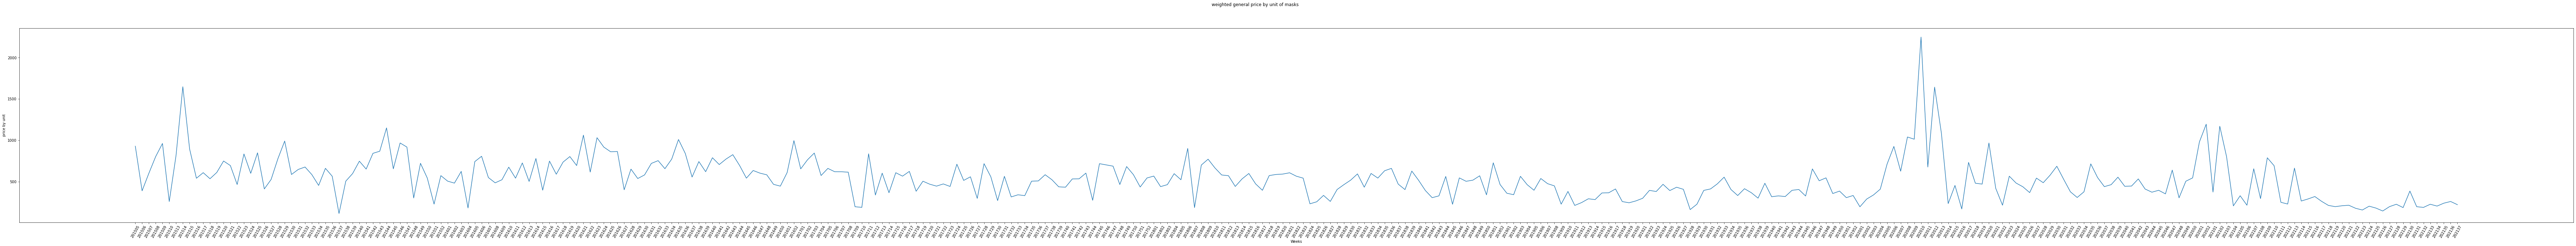

In [112]:
fig = plt.figure(figsize=(128, 10))
fig.suptitle('weighted general price by unit of masks')
index = np.arange(343)
values = N95_KN95_price_unit['weightedpricebyunit']

plt.plot(index,values)

plt.xlabel('Weeks')
plt.ylabel('price by unit')
plt.xticks(index, N95_KN95_price_unit['time'],rotation = 60)
plt.show()

# there is a sharp increase of price happend in the March of 2020.

In [113]:
# Related frequently bought together with masks

In [114]:
sql = "SELECT asin,bought_together_asin from amazon.frequently_bought_together"
frequentlyboughttogether = pd.read_sql(sql,conn)

In [115]:
frequentlyboughttogether.groupby('bought_together_asin').count()

,asin
bought_together_asin,
0989066207,2
1426216904,1
B00006RVTS,1
B00007E7IK,1
B00012QFPG,1
...,...
B08Y1KD5Y5,1
B08Y5NYQVS,1
B08ZY4DQDM,1


# the frequently bought together products can be classified into two types. 
# the first type is products that can protect people agaings virus or improve home environment, like sanitizer, hand soap and air purifier.
# the other type is products that enrich people's entertainments, such as yoga pat, colored pencil and so on.